# Choosing the best classifier for a data science problem

**The problem :** In this project, the client(a bank) needs to predict whether a loan case will be paid off or not. Hence, the datascience problem is to build a classification system to make this prediction for the client.

**Data :** The data used is a historical dataset from previous loan applications. It is in-house data and has been provided by the client

**Modelling :** The steps involve cleaning the data and applying different classification algorithms on the data. Following algorithms are used to build the models:

    - k-Nearest Neighbour
    - Decision Tree
    - Support Vector Machine
    - Logistic Regression

**Evaluation :** The results is reported as the accuracy of each classifier, using the following metrics wherever applicable:

    - Jaccard index
    - F1-score
    - LogLoss
    
**Result :** The aim is to find the best classifier for this specific dataset by accuracy evaluation methods.



In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



To see how many of each class is in the data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


To plot some columns and underestand data better:

In [7]:
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



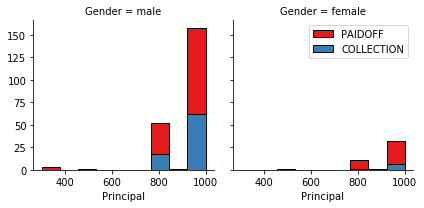

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

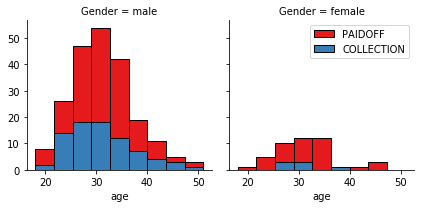

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

To look at the day of the week people get the loan 

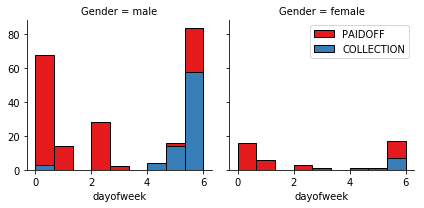

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


This shows that people who get the loan at the end of the week dont pay it off, so it is wise to use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

To look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


To convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


####  one hot encoding technique is used to convert categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

To define feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are the labels?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically this should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

# K Nearest Neighbor(KNN)
To find the best k for the model with the best accuracy. 
Splitting the train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       , 0.68571429,
       0.72857143, 0.72857143, 0.72857143, 0.7       ])

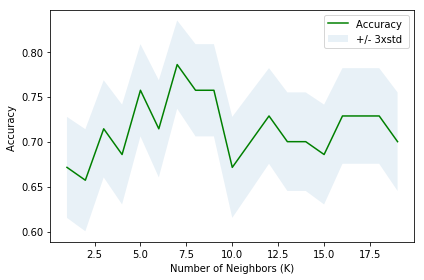

In [22]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [23]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


# Decision Tree

In [24]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trainset.shape,  y_trainset.shape)
print ('Test set:', X_testset.shape,  y_testset.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [25]:
from sklearn.tree import DecisionTreeClassifier
maxdepths = 15
mean_acc = np.zeros((maxdepths-1))


for n in range(3,maxdepths+1):
    
    #Train Model and Predict  
    dTree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_trainset,y_trainset)
    predTree = dTree.predict(X_testset)
    mean_acc[n-3] = metrics.accuracy_score(y_testset, predTree)
mean_acc[1:maxdepths-2,]

array([0.61428571, 0.64285714, 0.77142857, 0.75714286, 0.75714286,
       0.65714286, 0.7       , 0.7       , 0.7       , 0.71428571,
       0.72857143, 0.72857143])

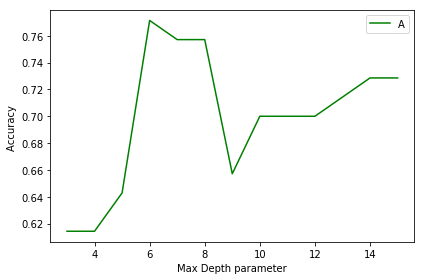

In [26]:
plt.plot(range(3,maxdepths+1),mean_acc[0:maxdepths-2,],'g')
plt.legend(('Accuracy '))
plt.ylabel('Accuracy ')
plt.xlabel('Max Depth parameter')
plt.tight_layout()
plt.show()

In [27]:
print("DecisionTrees's Accuracy: ", mean_acc.max(),"with max depth =", mean_acc.argmax()+3)

DecisionTrees's Accuracy:  0.7714285714285715 with max depth = 6


# Support Vector Machine

In [28]:
X_trainsvm, X_testsvm, y_trainsvm, y_testsvm = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_trainsvm.shape,  y_trainsvm.shape)
print ('Test set:', X_testsvm.shape,  y_testsvm.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [29]:
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
import warnings
warnings.filterwarnings('ignore')
clf1 = svm.SVC(kernel='linear')
clf1.fit(X_trainsvm, y_trainsvm) 
yhatsvm1 = clf1.predict(X_testsvm)
print("Avg F1-score linear kernel: %.4f" % f1_score(y_testsvm, yhatsvm1, average='weighted'))
print("Jaccard score linear kernel: %.4f" % jaccard_similarity_score(y_testsvm, yhatsvm1))

clf2 = svm.SVC(kernel='rbf')
clf2.fit(X_trainsvm, y_trainsvm) 
yhatsvm2 = clf2.predict(X_testsvm)
print("Avg F1-score rbf kernel: %.4f" % f1_score(y_testsvm, yhatsvm2, average='weighted'))
print("Jaccard score rbf kernel: %.4f" % jaccard_similarity_score(y_testsvm, yhatsvm2))

clf3 = svm.SVC(kernel='poly')
clf3.fit(X_trainsvm, y_trainsvm) 
yhatsvm3 = clf3.predict(X_testsvm)
print("Avg F1-score polynomial kernel: %.4f" % f1_score(y_testsvm, yhatsvm3, average='weighted'))
print("Jaccard score polynomial kernel: %.4f" % jaccard_similarity_score(y_testsvm, yhatsvm3))

clf4 = svm.SVC(kernel='sigmoid')
clf4.fit(X_trainsvm, y_trainsvm) 
yhatsvm4 = clf4.predict(X_testsvm)
print("Avg F1-score sigmoid kernel: %.4f" % f1_score(y_testsvm, yhatsvm4, average='weighted'))
print("Jaccard score sigmoid kernel: %.4f" % jaccard_similarity_score(y_testsvm, yhatsvm4))

Avg F1-score linear kernel: 0.6914
Jaccard score linear kernel: 0.7857
Avg F1-score rbf kernel: 0.7276
Jaccard score rbf kernel: 0.7429
Avg F1-score polynomial kernel: 0.7065
Jaccard score polynomial kernel: 0.7714
Avg F1-score sigmoid kernel: 0.6893
Jaccard score sigmoid kernel: 0.7429


# Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
from sklearn.model_selection import train_test_split
X_trainLR, X_testLR, y_trainLR, y_testLR = train_test_split( X, y, test_size=0.2, random_state=9)
print ('Train set:', X_trainLR.shape,  y_trainLR.shape)
print ('Test set:', X_testLR.shape,  y_testLR.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [32]:
LR2 = LogisticRegression(C=0.1, solver='liblinear').fit(X_trainLR,y_trainLR)
yhat2 = LR2.predict(X_testLR)
yhat_prob2 = LR2.predict_proba(X_testLR)
print("jaccard_similarity_score: %.2f" % jaccard_similarity_score(y_testLR, yhat2))
print ("LogLoss: : %.2f" % log_loss(y_testLR, yhat_prob2))
print (classification_report(y_testLR, yhat2))

jaccard_similarity_score: 0.80
LogLoss: : 0.43
              precision    recall  f1-score   support

  COLLECTION       0.50      0.14      0.22        14
     PAIDOFF       0.82      0.96      0.89        56

   micro avg       0.80      0.80      0.80        70
   macro avg       0.66      0.55      0.55        70
weighted avg       0.75      0.80      0.75        70



In [49]:
LR3 = LogisticRegression(C=0.1, solver='sag').fit(X_trainLR,y_trainLR)
yhat3 = LR3.predict(X_testLR)
yhat_prob3 = LR3.predict_proba(X_testLR)
print("jaccard_similarity_score: %.2f" % jaccard_similarity_score(y_testLR, yhat3))
print ("LogLoss: : %.2f" % log_loss(y_testLR, yhat_prob3))
print (classification_report(y_testLR, yhat3))

jaccard_similarity_score: 0.80
LogLoss: : 0.41
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.80      1.00      0.89        56

   micro avg       0.80      0.80      0.80        70
   macro avg       0.40      0.50      0.44        70
weighted avg       0.64      0.80      0.71        70



In [50]:
LR4 = LogisticRegression(C=0.1, solver='newton-cg').fit(X_trainLR,y_trainLR)
yhat4 = LR4.predict(X_testLR)
yhat_prob4 = LR4.predict_proba(X_testLR)
print("jaccard_similarity_score: %.2f" % jaccard_similarity_score(y_testLR, yhat4))
print ("LogLoss: : %.2f" % log_loss(y_testLR, yhat_prob4))
print (classification_report(y_testLR, yhat4))

jaccard_similarity_score: 0.80
LogLoss: : 0.41
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.80      1.00      0.89        56

   micro avg       0.80      0.80      0.80        70
   macro avg       0.40      0.50      0.44        70
weighted avg       0.64      0.80      0.71        70



# Model Evaluation using Test set

In [33]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, load the test set:

### Load Test set for evaluation 

In [35]:
test_df = pd.read_csv('loan_test.csv')
print(test_df.shape)
test_df.head()

(54, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [36]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [37]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [38]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [39]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       PAIDOFF        0.744186
        COLLECTION     0.255814
1       PAIDOFF        0.727273
        COLLECTION     0.272727
Name: loan_status, dtype: float64

In [40]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
test_df[['Principal','terms','age','Gender','education']].head()
testFeature = test_df[['Principal','terms','age','Gender','weekend']]
testFeature = pd.concat([testFeature,pd.get_dummies(test_df['education'])], axis=1)
testFeature.drop(['Master or Above'], axis = 1,inplace=True)
testFeature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [41]:
testX = testFeature
testX[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [42]:
testy = test_df['loan_status'].values
testy[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [43]:
testX= preprocessing.StandardScaler().fit(testX).transform(testX)
testX[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [44]:
# KNN with the best model selected from evaluation (k=7)    
k = 7
neigh7 = KNeighborsClassifier(n_neighbors = k).fit(X,y)
yhat7 = neigh7.predict(testX)
print("Avg F1-score : %.4f" % f1_score(testy, yhat7, average='weighted'))
print("Jaccard score: %.4f" % metrics.accuracy_score(testy, yhat7))


Avg F1-score : 0.7002
Jaccard score: 0.7222


In [45]:
# Decision Tree with the best model selected from evaluation (max_depth = 6) 
dTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6).fit(X,y)
predTree = dTree.predict(testX)
print("Avg F1-score : %.4f" % f1_score(testy, predTree, average='weighted'))
print("Jaccard score: %.4f" % metrics.accuracy_score(testy, predTree))

Avg F1-score : 0.7007
Jaccard score: 0.7407


In [46]:
# SVM with the best model selected from evaluation (kernel='linear')
clf1 = svm.SVC(kernel='linear')
clf1.fit(X, y) 
yhatsvm1 = clf1.predict(testX)
print("Avg F1-score  :  %.4f" % f1_score(testy, yhatsvm1, average='weighted'))
print("Jaccard score :  %.4f" % jaccard_similarity_score(testy, yhatsvm1))

Avg F1-score  :  0.6304
Jaccard score :  0.7407


In [47]:
# Logistic Regression with the best model selected from evaluation (C=0.1,solver='liblinear')
LR2 = LogisticRegression(C=0.1, solver='liblinear').fit(X,y)
yhatLR = LR2.predict(testX)
yhat_probLR = LR2.predict_proba(testX)
print("Avg F1-score  : %.4f" % f1_score(testy, yhatLR, average='weighted'))
print("Jaccard score : %.4f" % jaccard_similarity_score(testy, yhatLR))
print("LogLoss       : %.4f" % log_loss(testy, yhat_probLR))


Avg F1-score  : 0.6718
Jaccard score : 0.7593
LogLoss       : 0.4800


# Report
Accuracy of the built model is reported using different evaluation metrics as shown below:

In [48]:
results = {'Algorithm':  ['KNN', 'Decision Tree','SVM','Logistic regression'],
        'Jaccard': [round(metrics.accuracy_score(testy, yhat7),2), round(metrics.accuracy_score(testy, predTree),2), round(jaccard_similarity_score(testy, yhatsvm1),2), round(jaccard_similarity_score(testy, yhatLR),2)],
        'F1-Score': [round(f1_score(testy, yhat7, average='weighted'),2), round(f1_score(testy, predTree, average='weighted'),2), round(f1_score(testy, yhatsvm1, average='weighted'),2), round(f1_score(testy, yhatLR, average='weighted'),2)],
        'LogLoss': ['NA', 'NA','NA',round(log_loss(testy, yhat_probLR),2)],
        }

Resultdf = pd.DataFrame (results, columns = ['Algorithm','Jaccard','F1-Score','LogLoss'])
Resultdf.style.hide_index()

Algorithm,Jaccard,F1-Score,LogLoss
KNN,0.72,0.7,NA
Decision Tree,0.74,0.7,NA
SVM,0.74,0.63,NA
Logistic regression,0.76,0.67,0.48


### The classifiers built based on the available data suggests a Logistic Regression Model with parameters (C=0.1,solver='liblinear')